# Rigid objects and modal analysis

The type of systems that we are interested in are usually described by many coupled oscillators with complex configurations. The number of degrees of freedom of these systems is usually very large, and the number of modes that can be excited is also very large. In this notebook we will see:

- How to use modal analysis to analyse and model these systems.
- Use a differentiable transfer function model to emulate the behaviour of the system with a reduced number of modes.

An undamped physical system which exhibits small deformations can be described by a set of coupled linear differential equations. The equations of motion for such a system can be written in matrix form as:

$$
\mathbf{M}\ddot{\mathbf{x}} + \mathbf{K}\mathbf{x} = \mathbf{f}
$$

<!-- + \mathbf{C}\dot{\mathbf{x}} -->
where $\mathbf{x}$ is the vector of time-dependent displacements, $\mathbf{M}$ is the mass matrix, $\mathbf{K}$ is the stiffness matrix and $\mathbf{f}$ is the vector of external forces. The matrices $\mathbf{M}$ and $\mathbf{K}$ are usually very large and sparse. The latter matrices can be assembled using diverse methods, such as finite element analysis.

## Assembling the matrices

In [1]:
import skfem
from skfem.models.elasticity import (
    linear_elasticity,
    lame_parameters,
    linear_stress
)
from skfem.helpers import ddot, dot, grad, sym_grad
from skfem import BilinearForm, ElementLineP0, ElementLineP1, ElementLineP2, Basis
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

rho = 0.1
k = 3000

@BilinearForm
def mass(u, v, w):
    return rho * u * v

@BilinearForm
def laplace(u, v, _):
    return k * dot(grad(u), grad(v))

mesh = skfem.MeshLine(np.linspace(0, 1, 1000))
element = ElementLineP1()
basis = Basis(mesh, element)

K = skfem.asm(laplace, basis)
M = skfem.asm(mass, basis)
K, M, _, _ = skfem.condense(K, M, D=mesh.boundary_nodes())

# lumped mass matrix
# M = rho * np.eye(K.shape[0])
M = M.todense()

From here and with these matrices we can build a state-space model of the system. The state-space model for our system is:

$$
\begin{bmatrix} \dot{\mathbf{x}} \\ \ddot{\mathbf{x}} \end{bmatrix} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & 0 \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \dot{\mathbf{x}} \end{bmatrix} + \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix} \mathbf{f}
$$

As before, we can then discretize the system and find the dynamics of the system using gradient descent. Working with such matrices is not very efficient, and we can use modal analysis to get a reduced model of the system.


## Diagonalisation of the matrices

Using modal expansion, we can substitute $\mathbf{x}=\mathbf{U} \mathbf{q}$ in the equation of motion:

$$
\mathbf{M}\ddot{\mathbf{x}} + \mathbf{K}\mathbf{x} = \mathbf{f} \\
\mathbf{M}\mathbf{U} \ddot{\mathbf{q}} + \mathbf{K}\mathbf{U} \mathbf{q} = \mathbf{f}
$$

Where $\mathbf{U}$ a matrix with orthogonal columns, and $\mathbf{q}$ is the vector of modal coordinates. We can premultiply by $\mathbf{U}^T$ to get:

$$
\mathbf{U}^T \mathbf{M}\mathbf{U} \ddot{\mathbf{q}} + \mathbf{U}^T \mathbf{K}\mathbf{U} \mathbf{q} = \mathbf{U}^T \mathbf{f}
$$

Replacing the mass and stiffness matrices by their diagonalized versions $\mathbf{U}^T \mathbf{M}\mathbf{U} = \hat{\mathbf{M}}$ and $\mathbf{U}^T \mathbf{K}\mathbf{U} = \hat{\mathbf{K}}$ we get:

$$
\hat{\mathbf{M}} \ddot{\mathbf{q}} + \hat{\mathbf{K}} \mathbf{q} = \mathbf{U}^T \mathbf{f}
$$

The matrix $\mathbf{U}$ is obtained by solving the generalized eigenvalue problem:

$$
\mathbf{K} \mathbf{U} = \mathbf{M} \mathbf{U} \Lambda
$$

where the matrix $\Lambda$ contains the eigenvalues of the system along its diagonal. The matrix $\mathbf{U}$ is the matrix of eigenvectors of the system, and it is orthogonal. The eigenvalues of the system are the squared natural frequencies of the system.

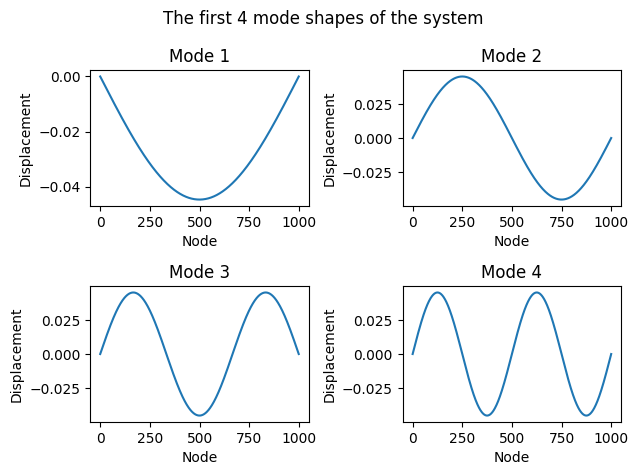

In [2]:
eigenvalues, eigenvectors = eigh(np.linalg.inv(M) @ K.todense())

# plot the first 4 modes of the system in 4 subplots
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
fig.suptitle("The first 4 mode shapes of the system")
for i in range(4):
    # add the boundary nodes to the eigenvectors
    # for a nicer plot
    eigenvectors_with_boundary = np.zeros((eigenvectors.shape[0] + 2, eigenvectors.shape[1]))
    eigenvectors_with_boundary[1:-1, i] = eigenvectors[:, i]

    axs[i].plot(eigenvectors_with_boundary[:, i])
    axs[i].set_title(f"Mode {i+1}")
    axs[i].set_xlabel("Node")
    axs[i].set_ylabel("Displacement")
plt.tight_layout()
plt.show()

## Modal solution

The diagonalized system $\hat{\mathbf{M}} \ddot{\mathbf{q}} + \hat{\mathbf{K}} \mathbf{q} = \mathbf{U}^T \mathbf{f}$ can be solved for each mode independently. The equation of motion in modal coordinates is:

$$
\ddot{\mathbf{q}} + \Lambda \mathbf{q} = \mathbf{U}^T \mathbf{f}
$$

where the eigenvectors $\mathbf{U}$ are normalized such that $\mathbf{U}^T \mathbf{M} \mathbf{U} = \mathbf{\hat{M}} = \mathbf{I}$ and $\hat{\mathbf{K}} = \mathbf{U}^T \mathbf{K}\mathbf{U} = \Lambda$. The solution for each mode is:

$$
q_i = a_i \sin(\omega_i t + \psi_i)
$$

where $a_i$, the modal amplitude, and $\psi_i$, the mode phase, are determined from the initial conditions.

In [3]:
# normalise the eigenvectors so that $\mathbf{U}^T \mathbf{M} \mathbf{U} = \mathbf{\hat{M}} = \mathbf{I}$
normed_eigenvectors = eigenvectors / np.sqrt(np.diag((eigenvectors.T @ M @ eigenvectors)))
omega = np.sqrt(eigenvalues)

In [4]:
# initial conditions for the system.

# make a gaussian centered in the middle of the string
x0 = 0.2 * np.exp(
    (-np.linspace(-1, 1, mesh.p.shape[1] - 2)**2)
    / 2 * 15**2
)[..., None]

# get the modal displacements 
q0 = np.linalg.inv(normed_eigenvectors) @ x0
a = q0 # this should be sqrt (shabana, 1996) but will also work without it

psi = np.arctan((omega[..., None] * q0) / q0)

Simulate the system for 1 second

In [5]:
sample_rate = 8_000
end_time = 0.05
t = np.linspace(0, end_time, int(sample_rate * end_time))
q = a * np.sin(
    omega[...,None] * t + psi
)

# back to the physical coordinates
x = normed_eigenvectors[:, :] @ q[:, :]

Display the result

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Set up the figure, the axis, and the plot elements
fig, ax = plt.subplots(figsize=(6, 3))
line, = ax.plot([], [], lw=2)
ax.set_ylim([-1.1 * np.max(np.abs(x)), 1.1 * np.max(np.abs(x))])
ax.set_xlim(0, x.shape[0])
ax.set_xlabel("Position")
ax.set_ylabel("Displacement")
ax.grid(True)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function which updates figure data. This is called sequentially
def animate(i):
    line.set_data(np.arange(x.shape[0]), x[:, i])
    ax.set_title(f"Wave on a String or Many Oscillators at t = {i}")
    return line,

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=x.shape[1], interval=50, blit=True)
plt.close(fig)
# To display the animation in the Jupyter notebook:
display(HTML(anim.to_html5_video()))


### Different positions, different modal responses

If we record the response of the system at different positions, we will get different mixing of the modes.

Text(0.5, 1.0, 'Modes of displacements at two different positions')

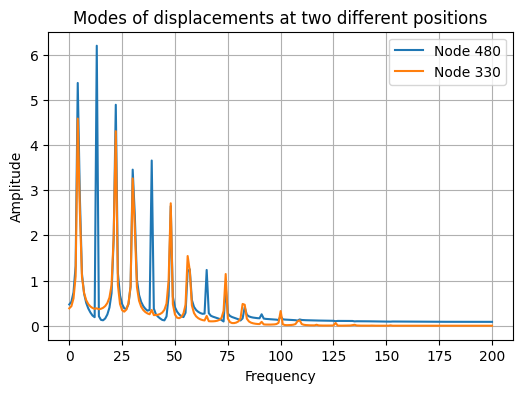

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.abs(np.fft.rfft(x[480, :])), label="Node 480")
ax.plot(np.abs(np.fft.rfft(x[330, :])), label="Node 330")
ax.legend()
ax.grid(True)
ax.set_xlabel("Frequency")
ax.set_ylabel("Amplitude")
ax.set_title("Modes of displacements at two different positions")

## Reducing the modes and learning a bank of resonators

We have just simulated a system with 1000 nodes. It is not coincidence that it results in the same solution for the linear wave equation 🌊 which we will see in a later section. Although we could parallelize the simulation, we haven't yet taken full advantage of the modal representation.

Now, we will use gradient descent to learn a bank of resonators that can emulate the behaviour of the system. In this notebook we will try to fit a the response of the system at a particular mode. 

### A differentiable filterbank

As we have seen in the previous sections of this tutorial, we can use gradient descent to learn the parameters of a filter. A two-pole filter is a good model for the simple harmonic oscillator. Many of these resonators can be used to model a system with many degrees of freedom, akin to the one we have just simulated. We will use a differentiable two-pole filter bank to model the behaviour of the system.

As before we will optimize the transfer function fo each filter in its pole-zero representation. The frequency response for each filter is:

$$
H(e^{j\omega})_{p} = \frac{{\prod_{i=1}^m {e^{j\omega} - z_i}}}{\prod_{i=1}^n {e^{j\omega} - p_i}},
$$

where each filter has $m$ zeros and $n$ poles. The total response of the filter bank is the sum of the responses of each filter:

$$
H(e^{j\omega}) = \sum_{p=1}^P H(e^{j\omega})_{p}
$$

where $P$ is the number of parallel filters in the bank.


In [46]:
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from torch.distributions.uniform import Uniform

torch.set_default_tensor_type(torch.FloatTensor)

class Filterbank(nn.Module):
    
    def __init__(
        self,
        n_parallel: int,
        n_biquads: int,
    ):
        super().__init__()

        self.n_parallel = n_parallel
        self.n_biquads = n_biquads
        
        self.p = nn.Parameter(
            torch.view_as_real(
                .999 * torch.exp(1j * Uniform(0, np.pi).sample((n_biquads, n_parallel)))
            )
        )
        self.z = nn.Parameter(
            torch.view_as_real(
                0.01 * torch.exp(1j * Uniform(0, np.pi).sample((n_biquads, n_parallel)))
            )
        )

        self.k = nn.Parameter(
            Uniform(0.1, 0.5).sample((n_biquads, n_parallel))
        )

    def forward(
        self,
        omega: torch.Tensor
    ) -> torch.Tensor:
        
        # sample frequencies
        e_ik = torch.exp(1j * omega)

        # z, p, k = self.to_zpk()
        p = torch.view_as_complex(self.p)
        z = torch.view_as_complex(self.z)
        k = self.k

        # Saturates the absolute value of the complex pole or zero as it approaches the unit circle, preventing filter instability.
        # mag = torch.abs(p)
        # p = p * nn.functional.tanh(mag) / mag

        # calculate the frequency response
        numerator = (k[...,None] * (e_ik - z[...,None])).prod(dim=-2).sum(dim=-2)
        denominator = (e_ik - p[...,None]).prod(dim=-2).sum(dim=-2)

        H = numerator / denominator

        return H


### Optimisation of the filterbank using gradient descent

We can use arbitrary configurations for approximating the frequency response of our physical system. In this example we use a a filterbank with 64 parallel filters, and where each filter is a cascaded filter with 4 biquads. Recall that in principle we would need a 1000 resonators to model the system, since we have 1000 nodes. However, we can use a much smaller number of resonators to model the system, since most of the modes have a very low contribution to the overall response of the system. 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(3407)

model = Filterbank(
    n_parallel=64,
    n_biquads=4
).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)

epochs = 20_000
node = 100

# magnitude response of the system at the 100th node
target_magnitude = torch.fft.rfft(
    torch.from_numpy(x[node, :]).float(),
).abs().to(device)

# we are only interested in the first half of the spectrum
# and our system is discrete, so we just sample up to pi
sample_omega = torch.linspace(0, np.pi, target_magnitude.shape[0]).to(device)

bar = tqdm(range(epochs))
for i in bar:
    optimiser.zero_grad()
    opt_freq_response = model(sample_omega)
    opt_magnitude = opt_freq_response.abs()
    loss = torch.nn.functional.mse_loss(
        (opt_magnitude),
        (target_magnitude)
    )
    loss += 0.2 * torch.nn.functional.mse_loss(
        (opt_magnitude.log()),
        (target_magnitude.log())
    )
    loss.backward()
    optimiser.step()
    bar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.0223: 100%|██████████| 20000/20000 [00:26<00:00, 752.17it/s]


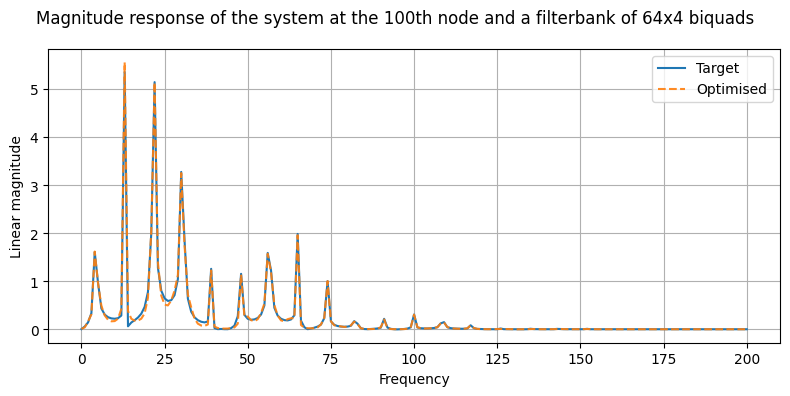

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig.suptitle("Magnitude response of the system at the 100th node and a filterbank of 64x4 biquads")
ax.plot((target_magnitude).detach().cpu().numpy(), label="Target")
ax.plot((opt_magnitude).detach().cpu().numpy(), label="Optimised", alpha=0.9, linestyle="--")
ax.legend()
ax.set_xlabel("Frequency")
ax.set_ylabel("Linear magnitude")
ax.grid(True)
plt.tight_layout()

## Conclusion

We have used modal analysis to find the modes of a system with 1000 degrees of freedom. Although we have used a very simple system, the same approach can be used for complex geometries. In fact, modal analysis can be used for analysis of very complex structures with thousands of degrees of freedom and inhomogeneous materials. We have also seen how we can use a differentiable *proxy* model to emulate the behaviour of the system with a reduced number of modes. Also, for the sake of simplicity we have used an undamped system, but the same approach applies also to damped systems. 

In this notebook we have only fit the response at a single physical location. In reality we might also want to fit the response when the geometry and material properties of the system change. For this, we can neural network which takes the physical location, geometrical and material information as input. This is the approach that we took in https://github.com/rodrigodzf/neuralresonator. The latter approach is more general in that it can be used to approximate the response of real systems. While classical approaches to system identification are faster and more accurate, they cannot be used in an end-to-end fashion with arbitrary features (e.g. geometry, material properties, etc.)
